<a href="https://colab.research.google.com/github/Z4HRA-S/Solar_Panel_Object_Detection/blob/main/FPN_segmentation_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Read the Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive/Colab\ Notebooks/proactive/

/content/drive/MyDrive/Colab Notebooks/proactive


In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
import torchvision.transforms.functional as TF
import torch
from torchvision.ops import masks_to_boxes
import matplotlib.patches as patches

In [ ]:
def plot(image,label,box=None):
  image = image.transpose(0,2).transpose(0,1).detach().numpy()
  label = label.squeeze().detach().numpy()
  i, (im1) = plt.subplots(1,2)
  i.set_figwidth(5)
  im1[0].imshow(image)
  if box is not None:
    rect = patches.Rectangle((box[0],box[1]), box[2]-box[0], box[3]-box[1],
                             linewidth=1, edgecolor='r', facecolor='none')
    im1[0].add_patch(rect)

  im1[1].imshow(label)

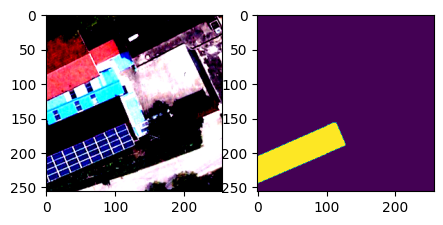

In [ ]:
img =TF.to_tensor(Image.open("processed_data/1.bmp"))
msk = TF.to_tensor(TF.to_grayscale(Image.open("processed_data/1_mask.bmp")))
plot(img,msk)

## Bounding Box
For the task of object detection, we need to convert the segmentation masks into bounding boxes, so we try the function from `torchvision`. The shortcoming of this method is that the bounding box will cover all panels at once, not every one of them separately.

At first, I wanted to consider all non-zero points which have a distance of 1 from each other as one object and group them. But the algorithm that I implemented was too slow and I had no time to correct it.

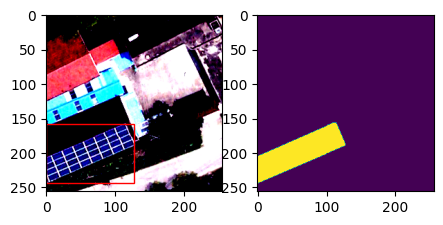

In [ ]:
boxes = masks_to_boxes(msk)
plot(img,msk,box = boxes[0])

#Define the Dataset

For this task, I read a [tutorial on the Pytorch website](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html) and customized its codes based on my need. Here I have defined a dataset class for my data.

In [ ]:
import os

class PanelImage(torch.utils.data.Dataset):
    def __init__(self, data_path, transforms=None):
        self.data_path = data_path
        self.transforms = transforms
        self.imgs = [img for img in listdir(data_path) if not img.endswith("mask.bmp")]

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_path, self.imgs[idx])
        mask_path = os.path.join(self.data_path,  f"{self.imgs[idx][:-4]}_mask.bmp")
        img = TF.to_tensor(Image.open(img_path).convert("RGB"))

        masks = Image.open(mask_path)
        masks = TF.to_tensor(TF.to_grayscale((masks)))
        boxes = masks_to_boxes(masks) if torch.nonzero(masks).size()[0]>0 else torch.Tensor([[0,0,0,0]])

        target = {}
        target["boxes"] = boxes
        target["masks"] = masks

        if self.transforms is not None:
            img = self.transforms(img)
            #target = self.transforms(target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
import utils

data = PanelImage("processed_data")

batch_size=20
len_train = 700
len_val= len(data) - len_train
train_set, val_set = torch.utils.data.random_split(data,[len_train, len_val])

data_loader = torch.utils.data.DataLoader(train_set,batch_size=batch_size,
                                          shuffle=True, pin_memory=True)

validation_data_loader = torch.utils.data.DataLoader(val_set,batch_size=batch_size,
                                          shuffle=True,pin_memory=True)

#Model Training

## Semantic Segmentation
At first I wanted to use [this](https://smp.readthedocs.io/en/latest/models.html#fpn) package, but some of the dependencies did not install. So I used [this github repo](https://github.com/AdeelH/pytorch-fpn).

In [ ]:
import torch

model = torch.hub.load(
	'AdeelH/pytorch-fpn',
	'make_fpn_resnet',
	name='resnet18',
	fpn_type='panoptic',
	num_classes=2,
	fpn_channels=256,
	in_channels=3,
	out_size=(256, 256)
)

Using cache found in /root/.cache/torch/hub/AdeelH_pytorch-fpn_master


###Explore the Model

First let's try the pre-trained model as-is. I want to see the structure of its output. I have downloaded an image from the net containing several people.

In [ ]:
model.eval()
test_img = data[0][0]
output = model(test_img.unsqueeze(dim=0))
#output[0].keys()

In [ ]:
output.size()

torch.Size([1, 2, 256, 256])

______________
 Let's visualize the output.

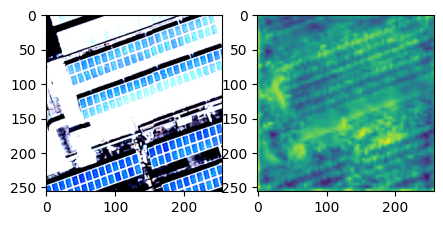

In [ ]:
plot(test_img,output[0][0])

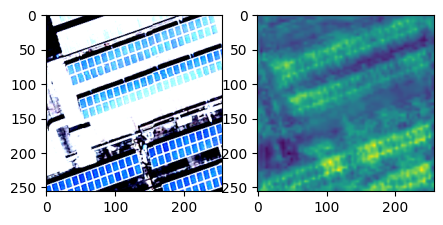

In [ ]:
plot(test_img,output[0][1])

### Train and Finetune the Model

Time to teach this model to act on our data :)

In [ ]:
lr=0.0005
epoch =40

In [ ]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = torch.hub.load(
	'AdeelH/pytorch-fpn',
	'make_fpn_resnet',
	name='resnet18',
	fpn_type='panoptic',
	num_classes=2,
	fpn_channels=256,
	in_channels=3,
	out_size=(256, 256)
)

model.to(device)
model.train()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
#optimizer = torch.optim.RMSprop(model.parameters(),lr=lr, weight_decay=wd, momentum=momentum, foreach=True)

def dice_score(pred, target):
  return 2 * torch.sum(pred * target) / (torch.sum(pred) + torch.sum(target))

def dice_loss(pred, target):
  intersect = torch.sum(pred * target)
  union = torch.sum(pred) + torch.sum(target)
  return 1 - ((2 * intersect + 1) / (union + 1))

loss_func = dice_loss


#loss_func = torch.nn.BCEWithLogitsLoss()

Using cache found in /root/.cache/torch/hub/AdeelH_pytorch-fpn_master


In [ ]:
train_loss=[]
val_loss=[]
for e in range(epoch):
  dice_coef = 0
  total_loss=0
  print(f"Epoch {e} ")
  for batch, data in enumerate(data_loader):
    img = data[0].to(device)
    mask = data[1]["masks"].to(device).float()

    output = model(img)
    output = output[:,1,:,:].unsqueeze(1)
    output = torch.nn.Sigmoid()(output)

    loss = loss_func(output, mask)
    total_loss += loss

    dice_coef += dice_score(output, mask)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  dice_coef/=round(len_train/batch_size)+1
  total_loss/=round(len_train/batch_size)+1
  train_loss.append(total_loss)
  print(f"train_loss: {total_loss.item():>7f}, dice_coef: {dice_coef.item():>7f}",end=" | ")

  with torch.no_grad():
    model.eval()
    epoch_val_loss = 0
    dice_coef=0

    for data in validation_data_loader:

      img = data[0].to(device)
      mask = data[1]["masks"].to(device).float()

      output = model(img)
      output = output[:,1,:,:].unsqueeze(1)
      output = torch.nn.Sigmoid()(output)
      dice_coef += dice_score(output, mask)

      epoch_val_loss += loss_func(output, mask)

    epoch_val_loss/=round(len_val/batch_size)+1
    dice_coef/=round(len_val/batch_size)+1

    print(f"val_loss: {epoch_val_loss.item():>7f} dice_coef: {dice_coef.item():>7f}")
    print("="*50)

    val_loss.append(epoch_val_loss)
  if val_loss[-1] <= min(val_loss):
    model_state = model.state_dict()
    opt_state = optimizer.state_dict()

torch.save({'epoch': epoch,
            'model_state_dict': model_state,
            'optimizer_state_dict': opt_state,
            'loss': train_loss,
          }, "saved_model/fpn_seg_w_2.pt")

Epoch 0 
train_loss: 0.626820, dice_coef: 0.345402 | val_loss: 0.452546 dice_coef: 0.214120
Epoch 1 
train_loss: 0.456986, dice_coef: 0.515236 | val_loss: 0.217499 dice_coef: 0.449167
Epoch 2 
train_loss: 0.224603, dice_coef: 0.747618 | val_loss: 0.154461 dice_coef: 0.512205
Epoch 3 
train_loss: 0.175383, dice_coef: 0.796839 | val_loss: 0.116832 dice_coef: 0.549835
Epoch 4 
train_loss: 0.161448, dice_coef: 0.810774 | val_loss: 0.124655 dice_coef: 0.542011
Epoch 5 
train_loss: 0.150977, dice_coef: 0.821245 | val_loss: 0.116037 dice_coef: 0.550629
Epoch 6 
train_loss: 0.141900, dice_coef: 0.830322 | val_loss: 0.112151 dice_coef: 0.554515
Epoch 7 
train_loss: 0.179117, dice_coef: 0.793105 | val_loss: 0.115673 dice_coef: 0.550993
Epoch 8 
train_loss: 0.147811, dice_coef: 0.824411 | val_loss: 0.110522 dice_coef: 0.556144
Epoch 9 
train_loss: 0.139204, dice_coef: 0.833018 | val_loss: 0.103055 dice_coef: 0.563612
Epoch 10 
train_loss: 0.133049, dice_coef: 0.839173 | val_loss: 0.098789 dice_co

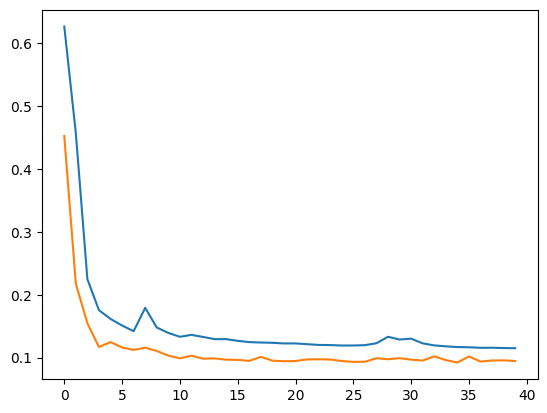

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(torch.stack(train_loss).cpu().detach().numpy(),label="train loss")
plt.plot(torch.stack(val_loss).cpu().detach().numpy(),label="validation loss")
plt.show()



---


**So, for now we can go to the Evaluation notebook and see the result there.**